In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

import itertools
import random

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]

col = ['date', 'incremental_cases', 'stay_at_home_announced', 'stay_at_home_effective', 'mean_temp',
       'min_temp', 'max_temp', 'dewpoint', 'sea_level_pressure', 'visibility',
       'wind_speed', 'max_wind_speed', 'precipitation', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'mean_temp_3d_avg',
       'max_temp_3d_avg', 'min_temp_3d_avg', 'dewpoint_3d_avg']

def create_features(df, label=None):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(np.int64)
    df['case_6_days_lag'] = df['incremental_cases'].shift(6)
    df['case_12_days_lag'] = df['incremental_cases'].shift(12)
    df['case_24_days_lag'] = df['incremental_cases'].shift(24)
    df['case_6_days_mean'] = df['incremental_cases'].rolling(window=6).mean()
    df['case_12_days_mean'] = df['incremental_cases'].rolling(window=12).mean()
    df['case_24_days_mean'] = df['incremental_cases'].rolling(window=24).mean()
    df['case_6_days_std'] = df['incremental_cases'].rolling(window=6).std()
    df['case_12_days_std'] = df['incremental_cases'].rolling(window=12).std()
    df['case_24_days_std'] = df['incremental_cases'].rolling(window=24).std()
    df['case_6_days_max'] = df['incremental_cases'].rolling(window=6).max()
    df['case_12_days_max'] = df['incremental_cases'].rolling(window=12).max()
    df['case_24_days_max'] = df['incremental_cases'].rolling(window=24).max()
    df['case_6_days_min'] = df['incremental_cases'].rolling(window=6).min()
    df['case_12_days_min'] = df['incremental_cases'].rolling(window=12).min()
    df['case_24_days_min'] = df['incremental_cases'].rolling(window=24).min()


    X = df[['dayofweek','quarter','month',
       'dayofyear','dayofmonth','weekofyear' , 'case_6_days_lag' , 'case_24_days_lag' , 'case_6_days_mean',
       "case_12_days_mean" ,"case_24_days_mean" ,"case_6_days_std" ,"case_12_days_std" ,"case_24_days_std",
       "case_6_days_max","case_12_days_max" ,"case_24_days_max" ,"case_6_days_min","case_12_days_min" ,"case_24_days_min"]]

    if label:
        y = df[label]
        return X, y
    return X

# NYC

In [45]:
nyc = data[data['entity'] == 'New York-New York City'].loc[:, col]
nyc['incremental_cases'] = nyc['incremental_cases'].astype('int')
nyc['date'] = pd.to_datetime(nyc['date'], format="%Y-%m-%d")
nyc['stay_at_home_announced'] = nyc['stay_at_home_announced'].map({'yes':1, 'no':0})
nyc['stay_at_home_effective'] = nyc['stay_at_home_effective'].map({'yes':1, 'no':0})

nyc = nyc.fillna(method='ffill')

train = nyc.iloc[:230, :]
test = nyc.iloc[230:, :]

X_train, y_train = create_features(train, label='incremental_cases')
X_test, y_test = create_features(test, label='incremental_cases')

# use this as a validation set for early stopping
val_x, val_y = X_train.tail(40), y_train.tail(40)
train_x, train_y = X_train.head(190), y_train.head(190)

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [500, 1000, 1500],
    'early_stopping_rounds': [5, 10, 20]
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

[0]	validation_0-rmse:705.05201
[1]	validation_0-rmse:620.53677
[2]	validation_0-rmse:557.93805
[3]	validation_0-rmse:501.81052
[4]	validation_0-rmse:440.13471
[5]	validation_0-rmse:390.91434
[6]	validation_0-rmse:340.79823
[7]	validation_0-rmse:300.40635
[8]	validation_0-rmse:263.00632
[9]	validation_0-rmse:229.97417
[10]	validation_0-rmse:201.16155
[11]	validation_0-rmse:179.78158
[12]	validation_0-rmse:161.83663
[13]	validation_0-rmse:147.11760
[14]	validation_0-rmse:133.94359
[15]	validation_0-rmse:124.00968
[16]	validation_0-rmse:117.52350
[17]	validation_0-rmse:111.46968
[18]	validation_0-rmse:106.71175
[19]	validation_0-rmse:103.82384
[20]	validation_0-rmse:102.23192
[21]	validation_0-rmse:101.21197
[22]	validation_0-rmse:100.84883
[23]	validation_0-rmse:101.14342
[24]	validation_0-rmse:102.26802
[25]	validation_0-rmse:103.40917
[26]	validation_0-rmse:105.18212
[27]	validation_0-rmse:106.35743
[28]	validation_0-rmse:107.61559
[29]	validation_0-rmse:108.90539
[30]	validation_0-rm

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'early_stopping_rounds': [5, 10, 20],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [500, 1000, 1500]},
             scoring='neg_mean_squared_error')

In [ ]:
best_params = grid_search.best_params_
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)
y_pred = best_model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

[0]	validation_0-rmse:705.05201
[1]	validation_0-rmse:620.53677
[2]	validation_0-rmse:557.93805
[3]	validation_0-rmse:501.81052
[4]	validation_0-rmse:440.13471
[5]	validation_0-rmse:390.91434
[6]	validation_0-rmse:340.79823
[7]	validation_0-rmse:300.40635
[8]	validation_0-rmse:263.00632
[9]	validation_0-rmse:229.97417
[10]	validation_0-rmse:201.16155
[11]	validation_0-rmse:179.78158
[12]	validation_0-rmse:161.83663
[13]	validation_0-rmse:147.11760
[14]	validation_0-rmse:133.94359
[15]	validation_0-rmse:124.00968
[16]	validation_0-rmse:117.52350
[17]	validation_0-rmse:111.46968
[18]	validation_0-rmse:106.71175
[19]	validation_0-rmse:103.82384
[20]	validation_0-rmse:102.23192
[21]	validation_0-rmse:101.21197
[22]	validation_0-rmse:100.84883
[23]	validation_0-rmse:101.14342
[24]	validation_0-rmse:102.26802
[25]	validation_0-rmse:103.40917
[26]	validation_0-rmse:105.18212
[27]	validation_0-rmse:106.35743
[28]	validation_0-rmse:107.61559
[29]	validation_0-rmse:108.90539
[30]	validation_0-rm

0.3146800920295759

In [ ]:
best_params

{'early_stopping_rounds': 20,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 500}

<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

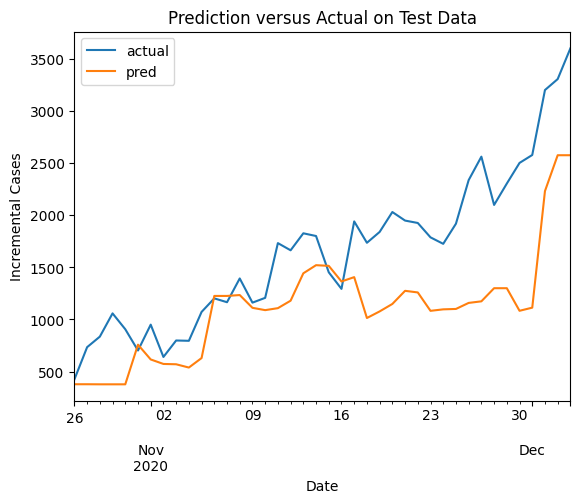

In [ ]:
prediction = pd.DataFrame({'actual':y_test.reset_index(drop = True),
              'pred':y_pred})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
param_grid = {
    'max_depth': [5, 7, 10, 12],
    'learning_rate': [0.005, 0.008, 0.01, 0.03, 0.05],
    'n_estimators': [100, 300, 500, 700, 1000],
    'early_stopping_rounds': [15, 20, 25, 30]
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

[0]	validation_0-rmse:745.84695
[1]	validation_0-rmse:701.19897
[2]	validation_0-rmse:664.36867
[3]	validation_0-rmse:631.11878
[4]	validation_0-rmse:592.64453
[5]	validation_0-rmse:562.69821
[6]	validation_0-rmse:528.06313
[7]	validation_0-rmse:501.11996
[8]	validation_0-rmse:470.16674
[9]	validation_0-rmse:445.08431
[10]	validation_0-rmse:421.30829
[11]	validation_0-rmse:397.80128
[12]	validation_0-rmse:372.24339
[13]	validation_0-rmse:348.12015
[14]	validation_0-rmse:327.41905
[15]	validation_0-rmse:306.94903
[16]	validation_0-rmse:287.59172
[17]	validation_0-rmse:271.37320
[18]	validation_0-rmse:256.10644
[19]	validation_0-rmse:239.84300
[20]	validation_0-rmse:224.59282
[21]	validation_0-rmse:211.90478
[22]	validation_0-rmse:200.49463
[23]	validation_0-rmse:190.00794
[24]	validation_0-rmse:179.53556
[25]	validation_0-rmse:169.95307
[26]	validation_0-rmse:161.31572
[27]	validation_0-rmse:153.27545
[28]	validation_0-rmse:146.17204
[29]	validation_0-rmse:140.03812
[30]	validation_0-rm

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'early_stopping_rounds': [15, 20, 25, 30],
                         'learning_rate': [0.005, 0.008, 0.01, 0.03, 0.05],
                         'max_depth': [5, 7, 10, 12],
                         'n_estimators': [100, 300, 500, 700, 1000]},
             scoring='neg_mean_squared_error')

In [ ]:
best_params = grid_search.best_params_
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)
y_pred = best_model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

[0]	validation_0-rmse:745.84695
[1]	validation_0-rmse:701.19897
[2]	validation_0-rmse:664.36867
[3]	validation_0-rmse:631.11878
[4]	validation_0-rmse:592.64453
[5]	validation_0-rmse:562.69821
[6]	validation_0-rmse:528.06313
[7]	validation_0-rmse:501.11996
[8]	validation_0-rmse:470.16674
[9]	validation_0-rmse:445.08431
[10]	validation_0-rmse:421.30829
[11]	validation_0-rmse:397.80128
[12]	validation_0-rmse:372.24339
[13]	validation_0-rmse:348.12015
[14]	validation_0-rmse:327.41905
[15]	validation_0-rmse:306.94903
[16]	validation_0-rmse:287.59172
[17]	validation_0-rmse:271.37320
[18]	validation_0-rmse:256.10644
[19]	validation_0-rmse:239.84300
[20]	validation_0-rmse:224.59282
[21]	validation_0-rmse:211.90478
[22]	validation_0-rmse:200.49463
[23]	validation_0-rmse:190.00794
[24]	validation_0-rmse:179.53556
[25]	validation_0-rmse:169.95307
[26]	validation_0-rmse:161.31572
[27]	validation_0-rmse:153.27545
[28]	validation_0-rmse:146.17204
[29]	validation_0-rmse:140.03812
[30]	validation_0-rm

0.3175718505330929

<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

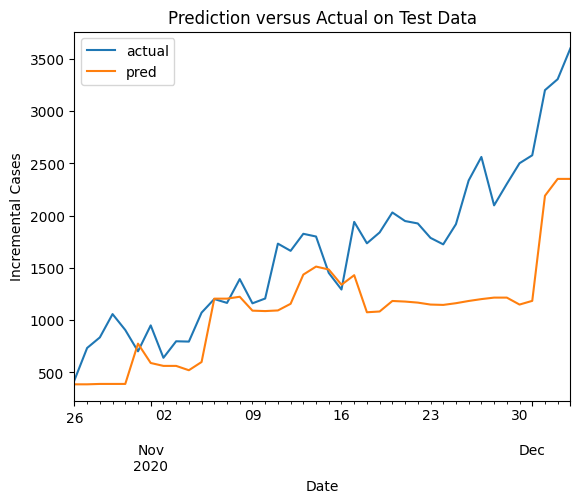

In [ ]:
prediction = pd.DataFrame({'actual':y_test.reset_index(drop = True),
              'pred':y_pred})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [ ]:
best_params

{'early_stopping_rounds': 15,
 'learning_rate': 0.05,
 'max_depth': 12,
 'n_estimators': 500}

In [ ]:
param_grid = {
    'max_depth': [10, 12, 14, 16],
    'learning_rate': [0.03, 0.05, 0.08, 0.1],
    'n_estimators': [300, 500, 700],
    'early_stopping_rounds': [13, 14, 15, 16, 17]
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

[0]	validation_0-rmse:745.84695
[1]	validation_0-rmse:701.19897
[2]	validation_0-rmse:664.36867
[3]	validation_0-rmse:631.11878
[4]	validation_0-rmse:592.64453
[5]	validation_0-rmse:562.69821
[6]	validation_0-rmse:528.06313
[7]	validation_0-rmse:501.11996
[8]	validation_0-rmse:470.16674
[9]	validation_0-rmse:445.08431
[10]	validation_0-rmse:421.30829
[11]	validation_0-rmse:397.80128
[12]	validation_0-rmse:372.24339
[13]	validation_0-rmse:348.12015
[14]	validation_0-rmse:327.41905
[15]	validation_0-rmse:306.94903
[16]	validation_0-rmse:287.59172
[17]	validation_0-rmse:271.37320
[18]	validation_0-rmse:256.10644
[19]	validation_0-rmse:239.84300
[20]	validation_0-rmse:224.59282
[21]	validation_0-rmse:211.90478
[22]	validation_0-rmse:200.49463
[23]	validation_0-rmse:190.00794
[24]	validation_0-rmse:179.53556
[25]	validation_0-rmse:169.95307
[26]	validation_0-rmse:161.31572
[27]	validation_0-rmse:153.27545
[28]	validation_0-rmse:146.17204
[29]	validation_0-rmse:140.03812
[30]	validation_0-rm

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'early_stopping_rounds': [13, 14, 15, 16, 17],
                         'learning_rate': [0.03, 0.05, 0.08, 0.1],
                         'max_depth': [10, 12, 14, 16],
                         'n_estimators': [300, 500, 700]},
             scoring='neg_mean_squared_error')

In [9]:
best_params = grid_search.best_params_
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)
y_pred = best_model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

[0]	validation_0-rmse:745.84695
[1]	validation_0-rmse:701.19897
[2]	validation_0-rmse:664.36867
[3]	validation_0-rmse:631.11878
[4]	validation_0-rmse:592.64453
[5]	validation_0-rmse:562.69821
[6]	validation_0-rmse:528.06313
[7]	validation_0-rmse:501.11996
[8]	validation_0-rmse:470.16674
[9]	validation_0-rmse:445.08431
[10]	validation_0-rmse:421.30829
[11]	validation_0-rmse:397.80128
[12]	validation_0-rmse:372.24339
[13]	validation_0-rmse:348.12015
[14]	validation_0-rmse:327.41905
[15]	validation_0-rmse:306.94903
[16]	validation_0-rmse:287.59172
[17]	validation_0-rmse:271.37320
[18]	validation_0-rmse:256.10644
[19]	validation_0-rmse:239.84300
[20]	validation_0-rmse:224.59282
[21]	validation_0-rmse:211.90478
[22]	validation_0-rmse:200.49463
[23]	validation_0-rmse:190.00794
[24]	validation_0-rmse:179.53556
[25]	validation_0-rmse:169.95307
[26]	validation_0-rmse:161.31572
[27]	validation_0-rmse:153.27545
[28]	validation_0-rmse:146.17204
[29]	validation_0-rmse:140.03812
[30]	validation_0-rm

0.3175718505330929

<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

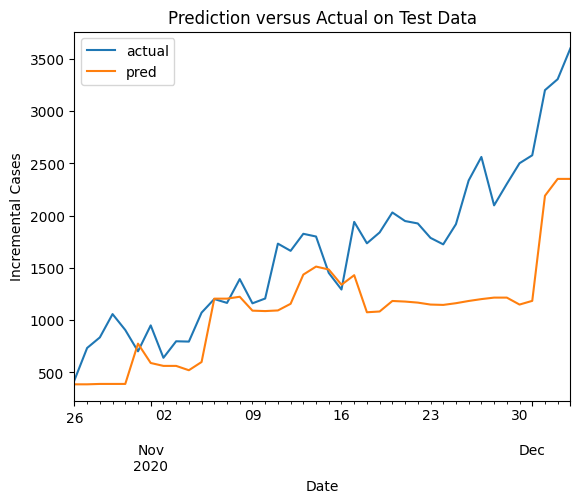

In [10]:
prediction = pd.DataFrame({'actual':y_test.reset_index(drop = True),
              'pred':y_pred})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [11]:
best_params

{'early_stopping_rounds': 13,
 'learning_rate': 0.05,
 'max_depth': 14,
 'n_estimators': 300}

In [12]:
param_grid = {
    'max_depth': [12, 13, 14, 15, 16],
    'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07],
    'n_estimators': [100, 200, 300, 400, 500],
    'early_stopping_rounds': [12, 13, 14, 15, 16]
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

[0]	validation_0-rmse:745.84695
[1]	validation_0-rmse:701.19897
[2]	validation_0-rmse:664.36867
[3]	validation_0-rmse:631.11878
[4]	validation_0-rmse:592.64453
[5]	validation_0-rmse:562.69821
[6]	validation_0-rmse:528.06313
[7]	validation_0-rmse:501.11996
[8]	validation_0-rmse:470.16674
[9]	validation_0-rmse:445.08431
[10]	validation_0-rmse:421.30829
[11]	validation_0-rmse:397.80128
[12]	validation_0-rmse:372.24339
[13]	validation_0-rmse:348.12015
[14]	validation_0-rmse:327.41905
[15]	validation_0-rmse:306.94903
[16]	validation_0-rmse:287.59172
[17]	validation_0-rmse:271.37320
[18]	validation_0-rmse:256.10644
[19]	validation_0-rmse:239.84300
[20]	validation_0-rmse:224.59282
[21]	validation_0-rmse:211.90478
[22]	validation_0-rmse:200.49463
[23]	validation_0-rmse:190.00794
[24]	validation_0-rmse:179.53556
[25]	validation_0-rmse:169.95307
[26]	validation_0-rmse:161.31572
[27]	validation_0-rmse:153.27545
[28]	validation_0-rmse:146.17204
[29]	validation_0-rmse:140.03812
[30]	validation_0-rm

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'early_stopping_rounds': [12, 13, 14, 15, 16],
                         'learning_rate': [0.03, 0.04, 0.05, 0.06, 0.07],
                         'max_depth': [12, 13, 14, 15, 16],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_squared_error')

In [13]:
best_params

{'early_stopping_rounds': 13,
 'learning_rate': 0.05,
 'max_depth': 14,
 'n_estimators': 300}

[0]	validation_0-rmse:745.84695
[1]	validation_0-rmse:701.19897
[2]	validation_0-rmse:664.36867
[3]	validation_0-rmse:631.11878
[4]	validation_0-rmse:592.64453
[5]	validation_0-rmse:562.69821
[6]	validation_0-rmse:528.06313
[7]	validation_0-rmse:501.11996
[8]	validation_0-rmse:470.16674
[9]	validation_0-rmse:445.08431
[10]	validation_0-rmse:421.30829
[11]	validation_0-rmse:397.80128
[12]	validation_0-rmse:372.24339
[13]	validation_0-rmse:348.12015
[14]	validation_0-rmse:327.41905
[15]	validation_0-rmse:306.94903
[16]	validation_0-rmse:287.59172
[17]	validation_0-rmse:271.37320
[18]	validation_0-rmse:256.10644
[19]	validation_0-rmse:239.84300
[20]	validation_0-rmse:224.59282
[21]	validation_0-rmse:211.90478
[22]	validation_0-rmse:200.49463
[23]	validation_0-rmse:190.00794
[24]	validation_0-rmse:179.53556
[25]	validation_0-rmse:169.95307
[26]	validation_0-rmse:161.31572
[27]	validation_0-rmse:153.27545
[28]	validation_0-rmse:146.17204
[29]	validation_0-rmse:140.03812
[30]	validation_0-rm

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

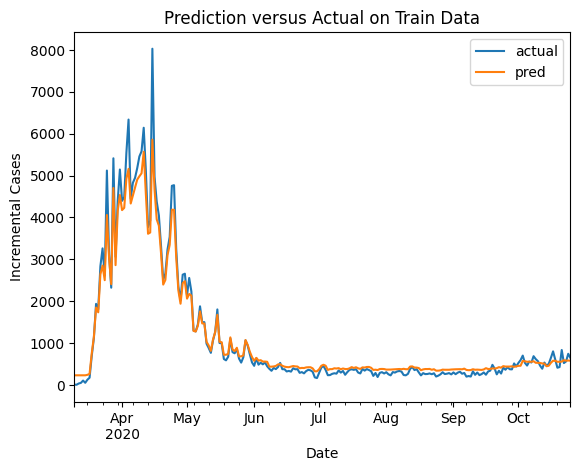

In [47]:
best_model = xgb.XGBRegressor(early_stopping_rounds=13,learning_rate=0.05, max_depth=14, n_estimators=300)
best_model.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

pred = best_model.predict(X_train)

prediction = pd.DataFrame({'actual':y_train.reset_index(drop = True),
              'pred':pred})
prediction['date'] = train['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.3175718505330929


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

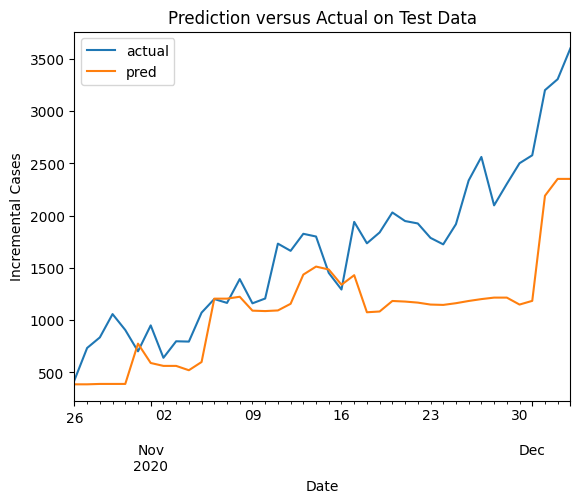

In [49]:
y_pred = best_model.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

prediction = pd.DataFrame({'actual':y_test.reset_index(drop = True),
              'pred':pred})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

# Clark

In [50]:
clark = data[data['entity'] == 'Nevada-Clark'].loc[:, col]
clark['incremental_cases'] = clark['incremental_cases'].astype('int')
clark['date'] = pd.to_datetime(clark['date'], format="%Y-%m-%d")
clark['stay_at_home_announced'] = clark['stay_at_home_announced'].map({'yes':1, 'no':0})
clark['stay_at_home_effective'] = clark['stay_at_home_effective'].map({'yes':1, 'no':0})

clark = clark.fillna(method='ffill')

train = clark.iloc[:230, :]
test = clark.iloc[230:, :]

X_train, y_train = create_features(train, label='incremental_cases')
X_test, y_test = create_features(test, label='incremental_cases')

# use this as a validation set for early stopping
val_x, val_y = X_train.tail(40), y_train.tail(40)
train_x, train_y = X_train.head(190), y_train.head(190)

In [51]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [500, 1000, 1500],
    'early_stopping_rounds': [5, 10, 20]
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

[0]	validation_0-rmse:168.03528
[1]	validation_0-rmse:163.57807
[2]	validation_0-rmse:158.74017
[3]	validation_0-rmse:147.49053
[4]	validation_0-rmse:140.84717
[5]	validation_0-rmse:138.91529
[6]	validation_0-rmse:131.94799
[7]	validation_0-rmse:128.34150
[8]	validation_0-rmse:127.67116
[9]	validation_0-rmse:126.26212
[10]	validation_0-rmse:124.57759
[11]	validation_0-rmse:122.10884
[12]	validation_0-rmse:121.78632
[13]	validation_0-rmse:121.50100
[14]	validation_0-rmse:121.56095
[15]	validation_0-rmse:118.72434
[16]	validation_0-rmse:116.19658
[17]	validation_0-rmse:116.31104
[18]	validation_0-rmse:115.18186
[19]	validation_0-rmse:115.88958
[20]	validation_0-rmse:115.23281
[21]	validation_0-rmse:115.84674
[22]	validation_0-rmse:116.43915
[23]	validation_0-rmse:116.82952
[24]	validation_0-rmse:117.15727
[25]	validation_0-rmse:116.06614
[26]	validation_0-rmse:115.73262
[27]	validation_0-rmse:116.15804


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'early_stopping_rounds': [5, 10, 20],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [500, 1000, 1500]},
             scoring='neg_mean_squared_error')

{'early_stopping_rounds': 10, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
[0]	validation_0-rmse:168.03528
[1]	validation_0-rmse:163.57807
[2]	validation_0-rmse:158.74017
[3]	validation_0-rmse:147.49053
[4]	validation_0-rmse:140.84717
[5]	validation_0-rmse:138.91529
[6]	validation_0-rmse:131.94799
[7]	validation_0-rmse:128.34150
[8]	validation_0-rmse:127.67116
[9]	validation_0-rmse:126.26212
[10]	validation_0-rmse:124.57759
[11]	validation_0-rmse:122.10884
[12]	validation_0-rmse:121.78632
[13]	validation_0-rmse:121.50100
[14]	validation_0-rmse:121.56095
[15]	validation_0-rmse:118.72434
[16]	validation_0-rmse:116.19658
[17]	validation_0-rmse:116.31104
[18]	validation_0-rmse:115.18186
[19]	validation_0-rmse:115.88958
[20]	validation_0-rmse:115.23281
[21]	validation_0-rmse:115.84674
[22]	validation_0-rmse:116.43915
[23]	validation_0-rmse:116.82952
[24]	validation_0-rmse:117.15727
[25]	validation_0-rmse:116.06614
[26]	validation_0-rmse:115.73262
[27]	validation_0-rmse:116.158

<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

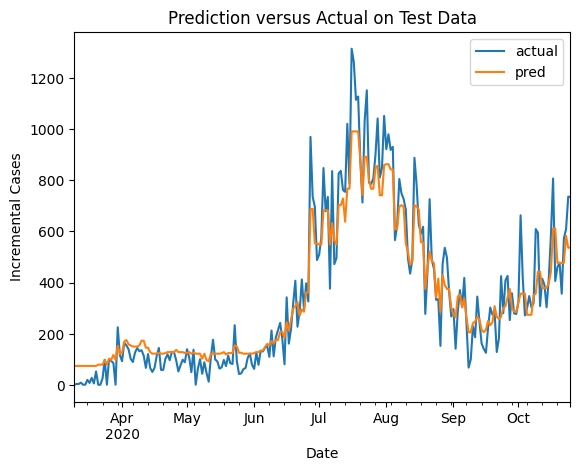

In [52]:
best_params = grid_search.best_params_
print(best_params)
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

pred = best_model.predict(X_train)

prediction = pd.DataFrame({'actual':y_train.reset_index(drop = True),
              'pred':pred})
prediction['date'] = train['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.4531994039684558


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

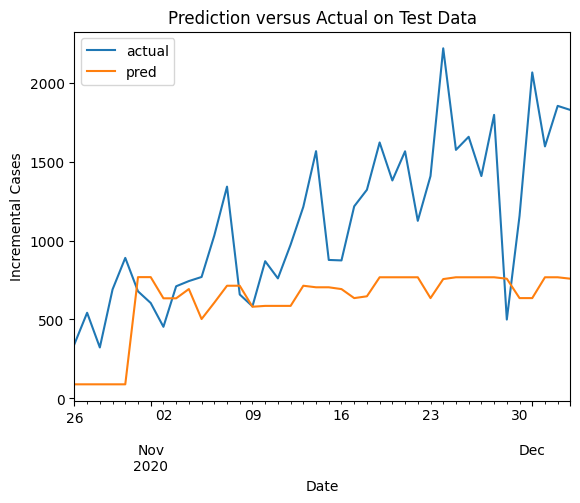

In [54]:
y_pred = best_model.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

prediction = pd.DataFrame({'actual':y_test.reset_index(drop = True),
              'pred':y_pred})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [55]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.03, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [300, 400, 500, 600, 700],
    'early_stopping_rounds': [8, 9, 10, 11, 12]
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

[0]	validation_0-rmse:175.09114
[1]	validation_0-rmse:169.73502
[2]	validation_0-rmse:166.77227
[3]	validation_0-rmse:163.20029
[4]	validation_0-rmse:158.87243
[5]	validation_0-rmse:155.33876
[6]	validation_0-rmse:151.60365
[7]	validation_0-rmse:151.58828
[8]	validation_0-rmse:147.12708
[9]	validation_0-rmse:147.19761
[10]	validation_0-rmse:146.40333
[11]	validation_0-rmse:139.72499
[12]	validation_0-rmse:138.00682
[13]	validation_0-rmse:136.29317
[14]	validation_0-rmse:135.32102
[15]	validation_0-rmse:134.45723
[16]	validation_0-rmse:134.16868
[17]	validation_0-rmse:134.11938
[18]	validation_0-rmse:133.81026
[19]	validation_0-rmse:133.74042
[20]	validation_0-rmse:134.09276
[21]	validation_0-rmse:134.09346
[22]	validation_0-rmse:134.48245
[23]	validation_0-rmse:134.82253
[24]	validation_0-rmse:133.89855
[25]	validation_0-rmse:133.75744
[26]	validation_0-rmse:133.81690
[27]	validation_0-rmse:132.99355
[28]	validation_0-rmse:131.50490
[29]	validation_0-rmse:131.44094
[30]	validation_0-rm

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'early_stopping_rounds': [8, 9, 10, 11, 12],
                         'learning_rate': [0.03, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [300, 400, 500, 600, 700]},
             scoring='neg_mean_squared_error')

{'early_stopping_rounds': 7, 'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 200}
[0]	validation_0-rmse:175.09114
[1]	validation_0-rmse:169.73502
[2]	validation_0-rmse:166.77227
[3]	validation_0-rmse:163.20029
[4]	validation_0-rmse:158.87243
[5]	validation_0-rmse:155.33876
[6]	validation_0-rmse:151.60365
[7]	validation_0-rmse:151.58828
[8]	validation_0-rmse:147.12708
[9]	validation_0-rmse:147.19761
[10]	validation_0-rmse:146.40333
[11]	validation_0-rmse:139.72499
[12]	validation_0-rmse:138.00682
[13]	validation_0-rmse:136.29317
[14]	validation_0-rmse:135.32102
[15]	validation_0-rmse:134.45723
[16]	validation_0-rmse:134.16868
[17]	validation_0-rmse:134.11938
[18]	validation_0-rmse:133.81026
[19]	validation_0-rmse:133.74042
[20]	validation_0-rmse:134.09276
[21]	validation_0-rmse:134.09346
[22]	validation_0-rmse:134.48245
[23]	validation_0-rmse:134.82253
[24]	validation_0-rmse:133.89855
[25]	validation_0-rmse:133.75744


<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

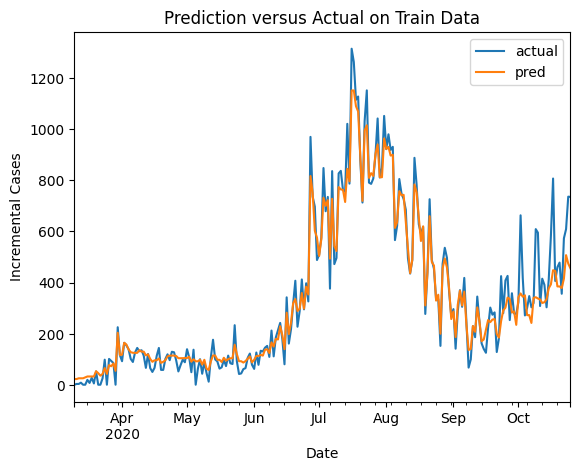

In [62]:
best_params = grid_search.best_params_
print(best_params)
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

pred = best_model.predict(X_train)

prediction = pd.DataFrame({'actual':y_train.reset_index(drop = True),
              'pred':pred})
prediction['date'] = train['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.45977998041652013


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

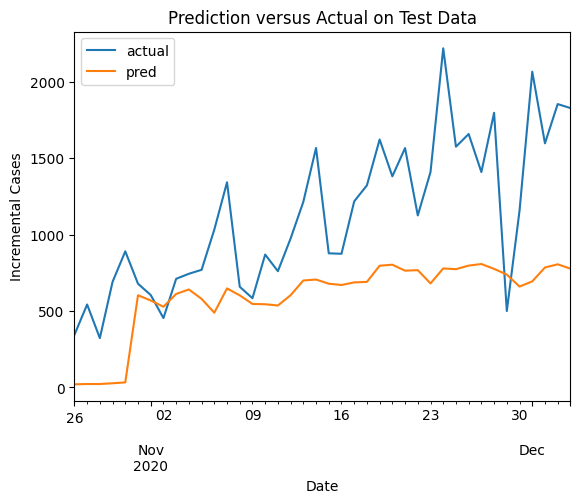

In [58]:
y_pred = best_model.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

prediction = pd.DataFrame({'actual':y_test.reset_index(drop = True),
              'pred':y_pred})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

# Suffolk

In [66]:
suffolk = data[data['entity'] == 'New York-Suffolk'].loc[:, col]
suffolk['incremental_cases'] = suffolk['incremental_cases'].astype('int')
suffolk['date'] = pd.to_datetime(suffolk['date'], format="%Y-%m-%d")
suffolk['stay_at_home_announced'] = suffolk['stay_at_home_announced'].map({'yes':1, 'no':0})
suffolk['stay_at_home_effective'] = suffolk['stay_at_home_effective'].map({'yes':1, 'no':0})

suffolk = suffolk.fillna(method='ffill')

train = suffolk.iloc[:230, :]
test = suffolk.iloc[230:, :]

X_train, y_train = create_features(train, label='incremental_cases')
X_test, y_test = create_features(test, label='incremental_cases')

# use this as a validation set for early stopping
val_x, val_y = X_train.tail(40), y_train.tail(40)
train_x, train_y = X_train.head(190), y_train.head(190)

In [67]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [500, 1000, 1500],
    'early_stopping_rounds': [5, 10, 20]
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

[0]	validation_0-rmse:153.34751
[1]	validation_0-rmse:137.09559
[2]	validation_0-rmse:122.33875
[3]	validation_0-rmse:110.48435
[4]	validation_0-rmse:99.36413
[5]	validation_0-rmse:88.75070
[6]	validation_0-rmse:79.61375
[7]	validation_0-rmse:71.27248
[8]	validation_0-rmse:64.55552
[9]	validation_0-rmse:58.35561
[10]	validation_0-rmse:52.52515
[11]	validation_0-rmse:47.40536
[12]	validation_0-rmse:42.90198
[13]	validation_0-rmse:39.21830
[14]	validation_0-rmse:36.36206
[15]	validation_0-rmse:33.62533
[16]	validation_0-rmse:31.23835
[17]	validation_0-rmse:29.46944
[18]	validation_0-rmse:28.04392
[19]	validation_0-rmse:26.90518
[20]	validation_0-rmse:26.04267
[21]	validation_0-rmse:25.39814
[22]	validation_0-rmse:24.77038
[23]	validation_0-rmse:24.52658
[24]	validation_0-rmse:24.36371
[25]	validation_0-rmse:24.24756
[26]	validation_0-rmse:24.16690
[27]	validation_0-rmse:23.90719
[28]	validation_0-rmse:23.94014
[29]	validation_0-rmse:23.98641
[30]	validation_0-rmse:24.05770
[31]	validatio

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'early_stopping_rounds': [5, 10, 20],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [500, 1000, 1500]},
             scoring='neg_mean_squared_error')

{'early_stopping_rounds': 20, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
[0]	validation_0-rmse:153.34751
[1]	validation_0-rmse:137.09559
[2]	validation_0-rmse:122.33875
[3]	validation_0-rmse:110.48435
[4]	validation_0-rmse:99.36413
[5]	validation_0-rmse:88.75070
[6]	validation_0-rmse:79.61375
[7]	validation_0-rmse:71.27248
[8]	validation_0-rmse:64.55552
[9]	validation_0-rmse:58.35561
[10]	validation_0-rmse:52.52515
[11]	validation_0-rmse:47.40536
[12]	validation_0-rmse:42.90198
[13]	validation_0-rmse:39.21830
[14]	validation_0-rmse:36.36206
[15]	validation_0-rmse:33.62533
[16]	validation_0-rmse:31.23835
[17]	validation_0-rmse:29.46944
[18]	validation_0-rmse:28.04392
[19]	validation_0-rmse:26.90518
[20]	validation_0-rmse:26.04267
[21]	validation_0-rmse:25.39814
[22]	validation_0-rmse:24.77038
[23]	validation_0-rmse:24.52658
[24]	validation_0-rmse:24.36371
[25]	validation_0-rmse:24.24756
[26]	validation_0-rmse:24.16690
[27]	validation_0-rmse:23.90719
[28]	validation_0-rms

<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

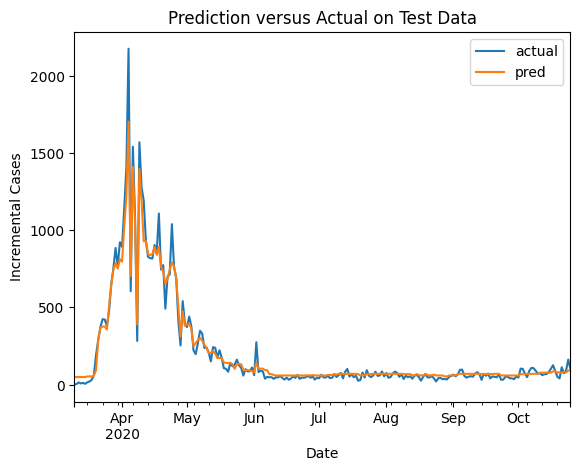

In [68]:
best_params = grid_search.best_params_
print(best_params)
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

pred = best_model.predict(X_train)

prediction = pd.DataFrame({'actual':y_train.reset_index(drop = True),
              'pred':pred})
prediction['date'] = train['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.3129474152791033


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

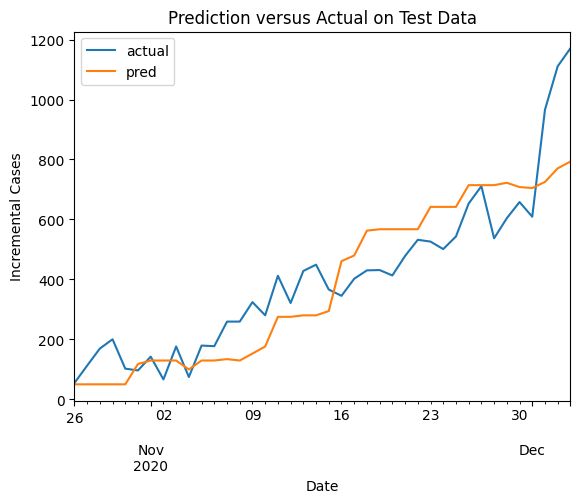

In [69]:
y_pred = best_model.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

prediction = pd.DataFrame({'actual':y_test.reset_index(drop = True),
              'pred':y_pred})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

In [70]:
param_grid = {
    'max_depth': [1, 2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'n_estimators': [300, 400, 500, 600, 700],
    'early_stopping_rounds': [15, 20, 25, 30]
}

xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3,
                           scoring='neg_mean_squared_error', n_jobs = -1)
grid_search.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

[0]	validation_0-rmse:145.71198
[1]	validation_0-rmse:124.24459
[2]	validation_0-rmse:105.14850
[3]	validation_0-rmse:88.59570
[4]	validation_0-rmse:75.71778
[5]	validation_0-rmse:64.11856
[6]	validation_0-rmse:55.48482
[7]	validation_0-rmse:48.45215
[8]	validation_0-rmse:42.23850
[9]	validation_0-rmse:37.23937
[10]	validation_0-rmse:32.88155
[11]	validation_0-rmse:30.43318
[12]	validation_0-rmse:28.37401
[13]	validation_0-rmse:27.31818
[14]	validation_0-rmse:27.28511
[15]	validation_0-rmse:26.96059
[16]	validation_0-rmse:26.48244
[17]	validation_0-rmse:26.47085
[18]	validation_0-rmse:26.24278
[19]	validation_0-rmse:26.19478
[20]	validation_0-rmse:26.19573
[21]	validation_0-rmse:26.18387
[22]	validation_0-rmse:26.18310
[23]	validation_0-rmse:26.18692
[24]	validation_0-rmse:26.23937
[25]	validation_0-rmse:25.55186
[26]	validation_0-rmse:25.55281
[27]	validation_0-rmse:25.16875
[28]	validation_0-rmse:25.16436
[29]	validation_0-rmse:25.34243
[30]	validation_0-rmse:25.33851
[31]	validation

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'early_stopping_rounds': [15, 20, 25, 30],
                         'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [300, 400, 500, 600, 700]},
             scoring='neg_mean_squared_error')

{'early_stopping_rounds': 20, 'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 300}
[0]	validation_0-rmse:145.71198
[1]	validation_0-rmse:124.24459
[2]	validation_0-rmse:105.14850
[3]	validation_0-rmse:88.59570
[4]	validation_0-rmse:75.71778
[5]	validation_0-rmse:64.11856
[6]	validation_0-rmse:55.48482
[7]	validation_0-rmse:48.45215
[8]	validation_0-rmse:42.23850
[9]	validation_0-rmse:37.23937
[10]	validation_0-rmse:32.88155
[11]	validation_0-rmse:30.43318
[12]	validation_0-rmse:28.37401
[13]	validation_0-rmse:27.31818
[14]	validation_0-rmse:27.28511
[15]	validation_0-rmse:26.96059
[16]	validation_0-rmse:26.48244
[17]	validation_0-rmse:26.47085
[18]	validation_0-rmse:26.24278
[19]	validation_0-rmse:26.19478
[20]	validation_0-rmse:26.19573
[21]	validation_0-rmse:26.18387
[22]	validation_0-rmse:26.18310
[23]	validation_0-rmse:26.18692
[24]	validation_0-rmse:26.23937
[25]	validation_0-rmse:25.55186
[26]	validation_0-rmse:25.55281
[27]	validation_0-rmse:25.16875
[28]	validation_0-rms

<Axes: title={'center': 'Prediction versus Actual on Train Data'}, xlabel='Date', ylabel='Incremental Cases'>

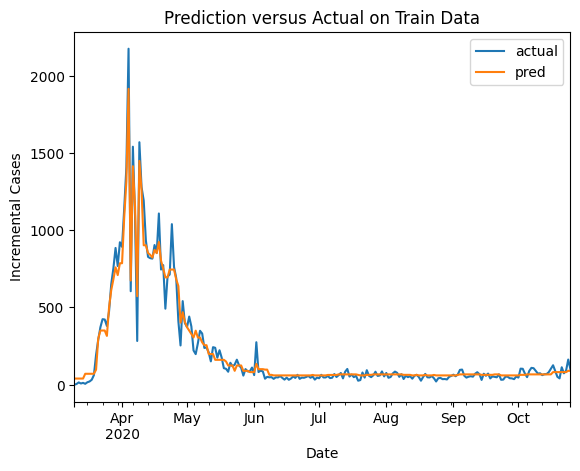

In [72]:
best_params = grid_search.best_params_
print(best_params)
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(train_x, train_y,
        eval_set=[(val_x, val_y)],
       verbose=True)

pred = best_model.predict(X_train)

prediction = pd.DataFrame({'actual':y_train.reset_index(drop = True),
              'pred':pred})
prediction['date'] = train['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Train Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')

0.3208602472590851


<Axes: title={'center': 'Prediction versus Actual on Test Data'}, xlabel='Date', ylabel='Incremental Cases'>

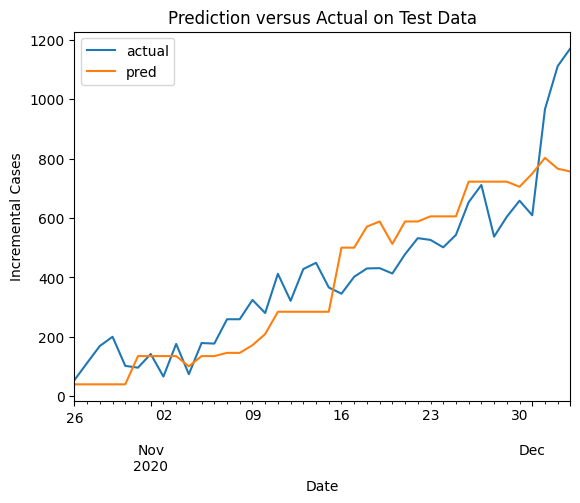

In [73]:
y_pred = best_model.predict(X_test)
print(mean_absolute_percentage_error(y_test, y_pred))

prediction = pd.DataFrame({'actual':y_test.reset_index(drop = True),
              'pred':y_pred})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'], title = 'Prediction versus Actual on Test Data',
                xlabel = 'Date', ylabel = 'Incremental Cases')